The aim of this notebook is to test the LM distance minimization procedure on real image.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import pathlib

from tyssue.generation import generate_ring
from tyssue.draw.plt_draw import quick_edge_draw
from tyssue.solvers.sheet_vertex_solver import Solver
from tyssue.config.draw import sheet_spec
from tyssue.draw.plt_draw import sheet_view
from tyssue.io.hdf5 import save_datasets

from tyssue_taylor.adjusters.adjust_annular import set_init_point, prepare_tensions, adjust_tensions
from tyssue_taylor.models.annular import AnnularGeometry as geom
from tyssue_taylor.models.annular import model
from tyssue_taylor.adjusters.cost_functions import _distance
from tyssue_taylor.segmentation.segment2D import generate_ring_from_image, normalize_scale
from tyssue_taylor.adjusters.force_inference import infer_forces

Error: IPOPT shared library failed to import


## Segmentation


Reseting datasets values with new specs


0.9999999973381805


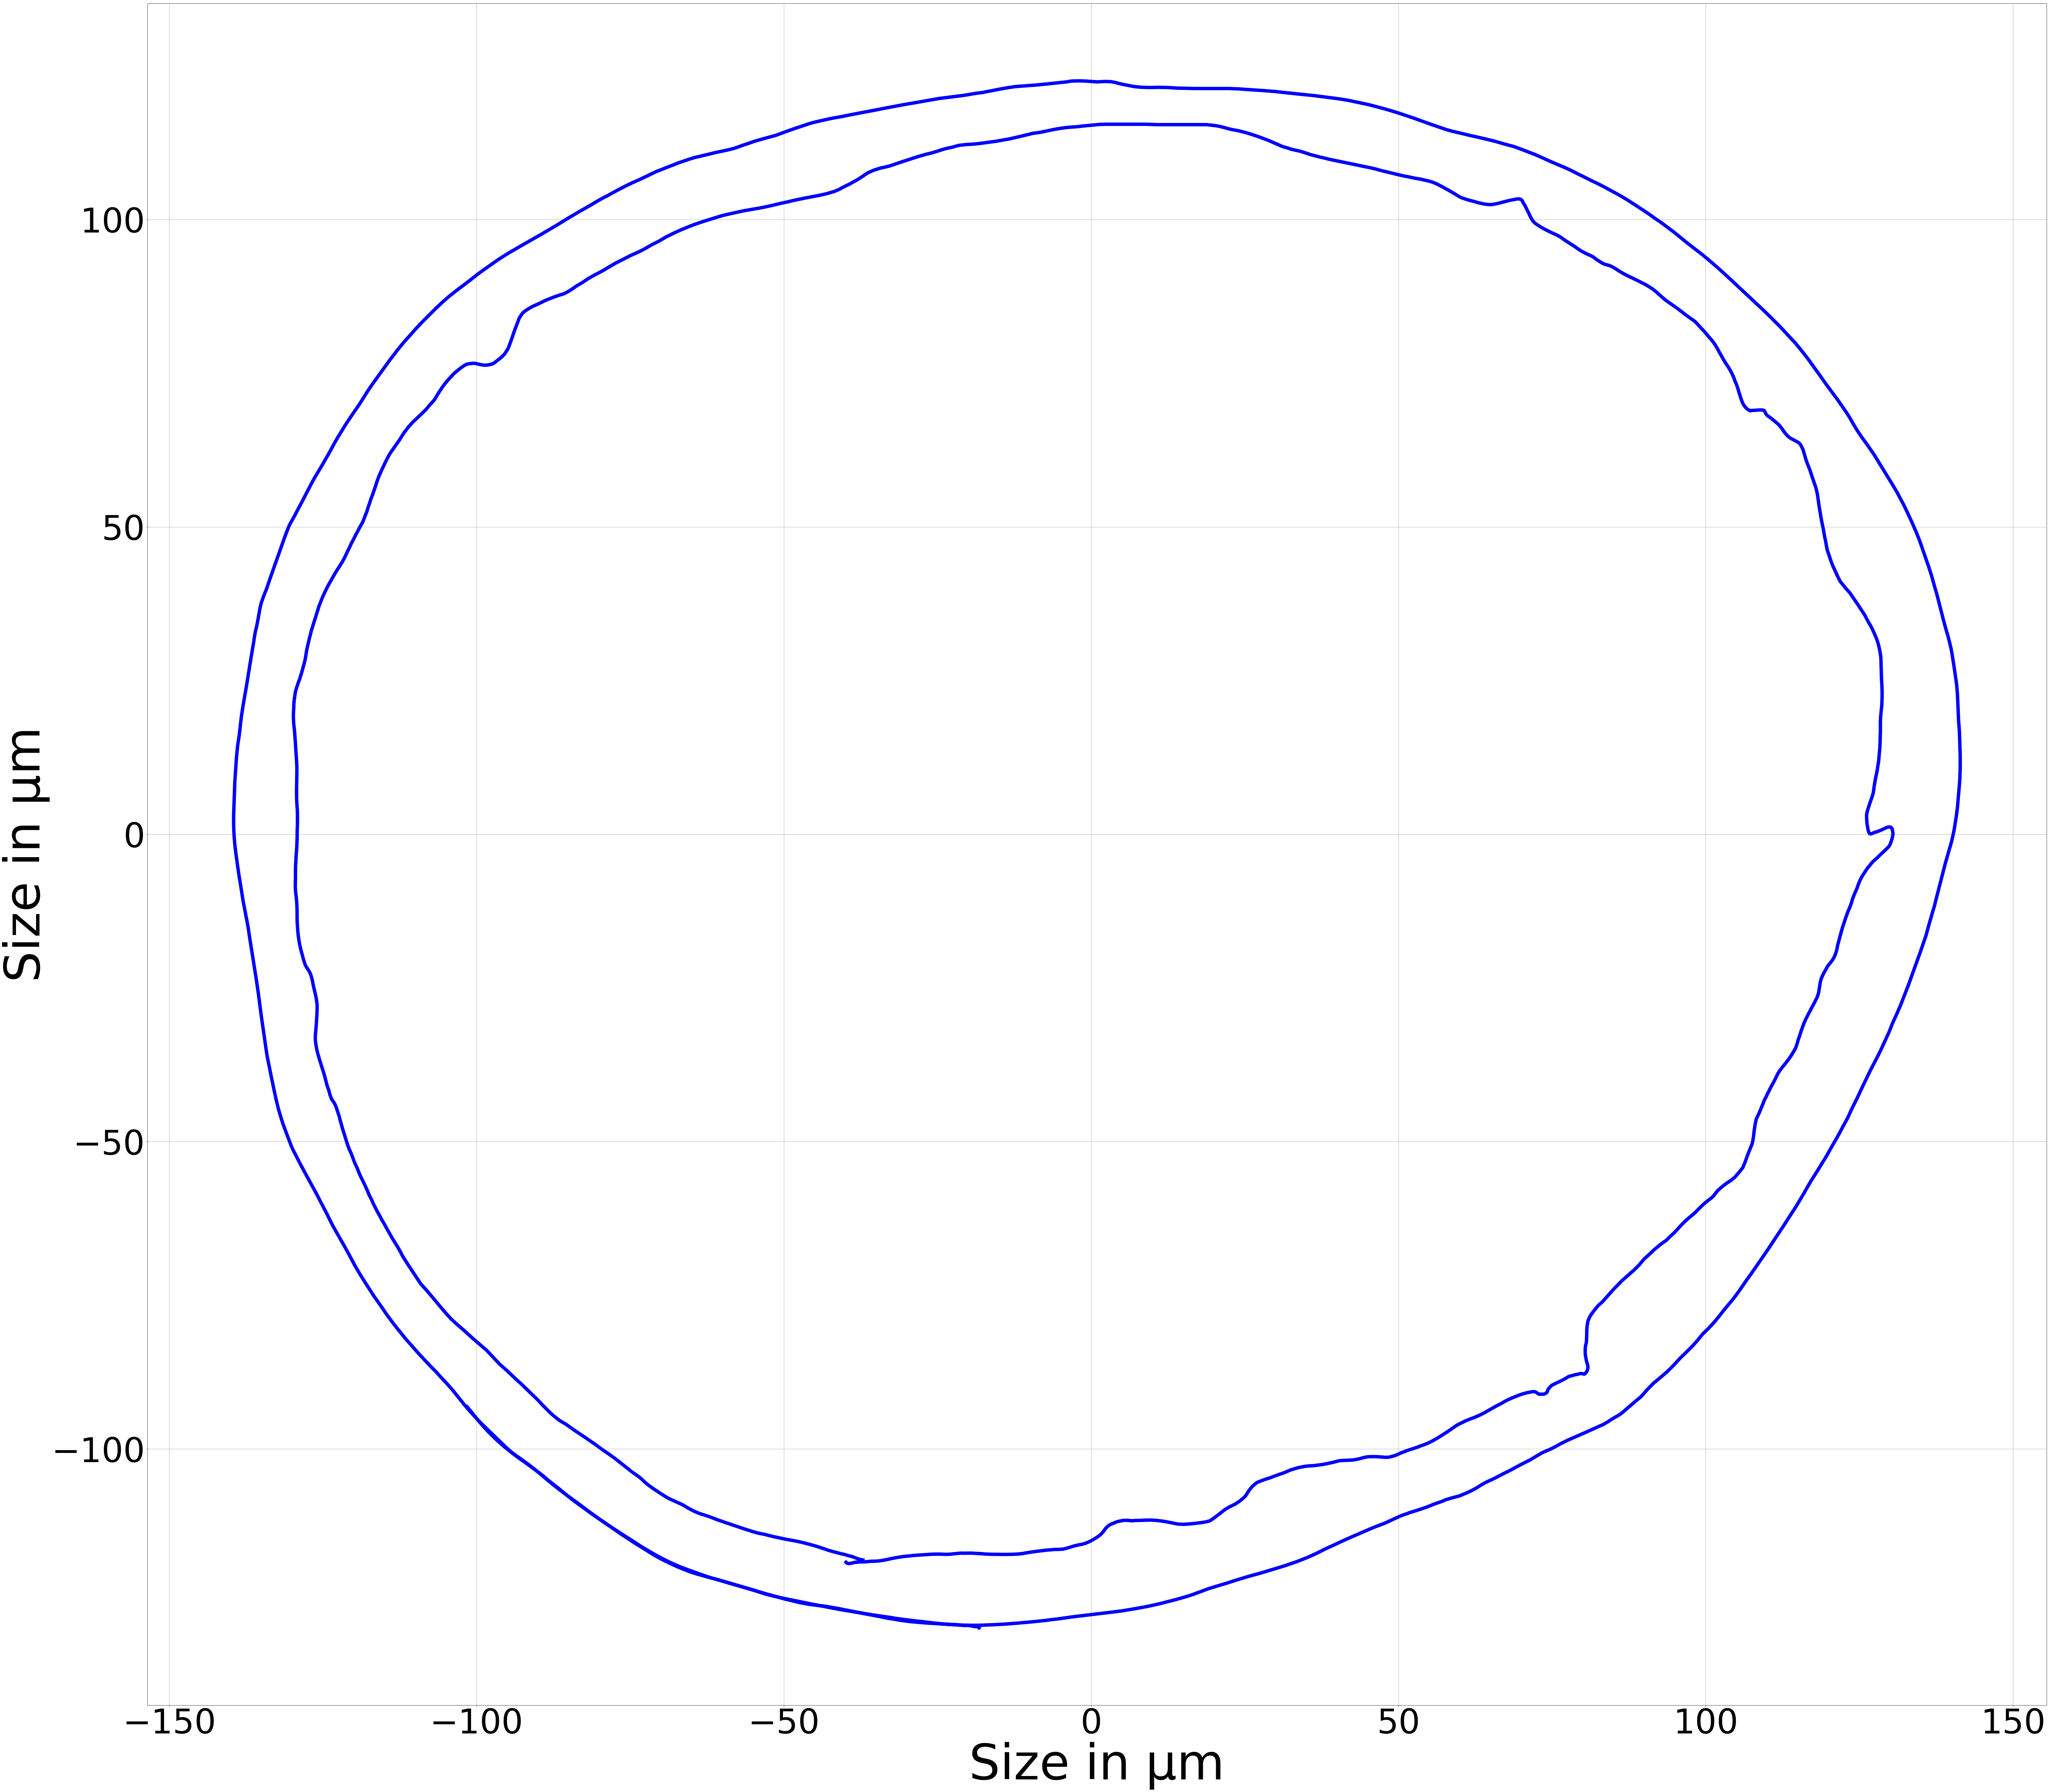

In [2]:
brigthfield_path = '../assets/sample_image_brightfield.tiff'
dapi_path = '../assets/CELLPROFILER_sample_image_dapi.tiff.csv'
#initialising the mesh
organo, inners, outers, centers = generate_ring_from_image(brigthfield_path, dapi_path)
Nf = organo.Nf
geom.update_all(organo)
#normalize_scale(organo, geom)
#alpha as proposed in the doc (in french) https://www.sharelatex.com/read/zdxptpnrryhc
alpha = 1 + np.sin(np.pi/Nf)/(np.mean(organo.face_df.area)*organo.settings['R_in']*np.sin(2*np.pi/Nf)-2*np.mean(organo.face_df.area)*
                             np.sin(2*np.pi/Nf)*(8-2*(np.sin(2*np.pi/Nf)**2-4)/(np.sin(np.pi/Nf)**4+8*np.sin(np.pi/Nf)**2)
                                                )*(organo.settings['R_in']+organo.settings['R_out']))
print(alpha)
alpha = 1.001
# Model parameters or specifications
specs = {
    'face':{
        'is_alive': 1,
        'prefered_area':  list(alpha*organo.face_df.area.values), 
        'area_elasticity': 1.,},
    'edge':{        
        'ux': 0.,
        'uy': 0.,
        'uz': 0.,
        'line_tension': 0.1,
        'is_active': 1
        },
    'vert':{
        'adhesion_strength': 0.,
        'x_ecm': 0.,
        'y_ecm': 0.,
        'is_active': 1
        },
    'settings': {
        'lumen_elasticity': 0.1,
        'lumen_prefered_vol': organo.settings['lumen_volume'],
        'lumen_volume': organo.settings['lumen_volume']
        }
    }

organo.update_specs(specs, reset=True)
geom.update_all(organo)
inners = inners[:int(2830/2)]
outers = outers[:int(outers.shape[0]/2)]

organo.vert_df[['x_ecm', 'y_ecm']] = organo.vert_df[['x', 'y']]

organo.vert_df.loc[organo.basal_verts, 'adhesion_strength'] = 0.01

fig, ax = plt.subplots()
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')

fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

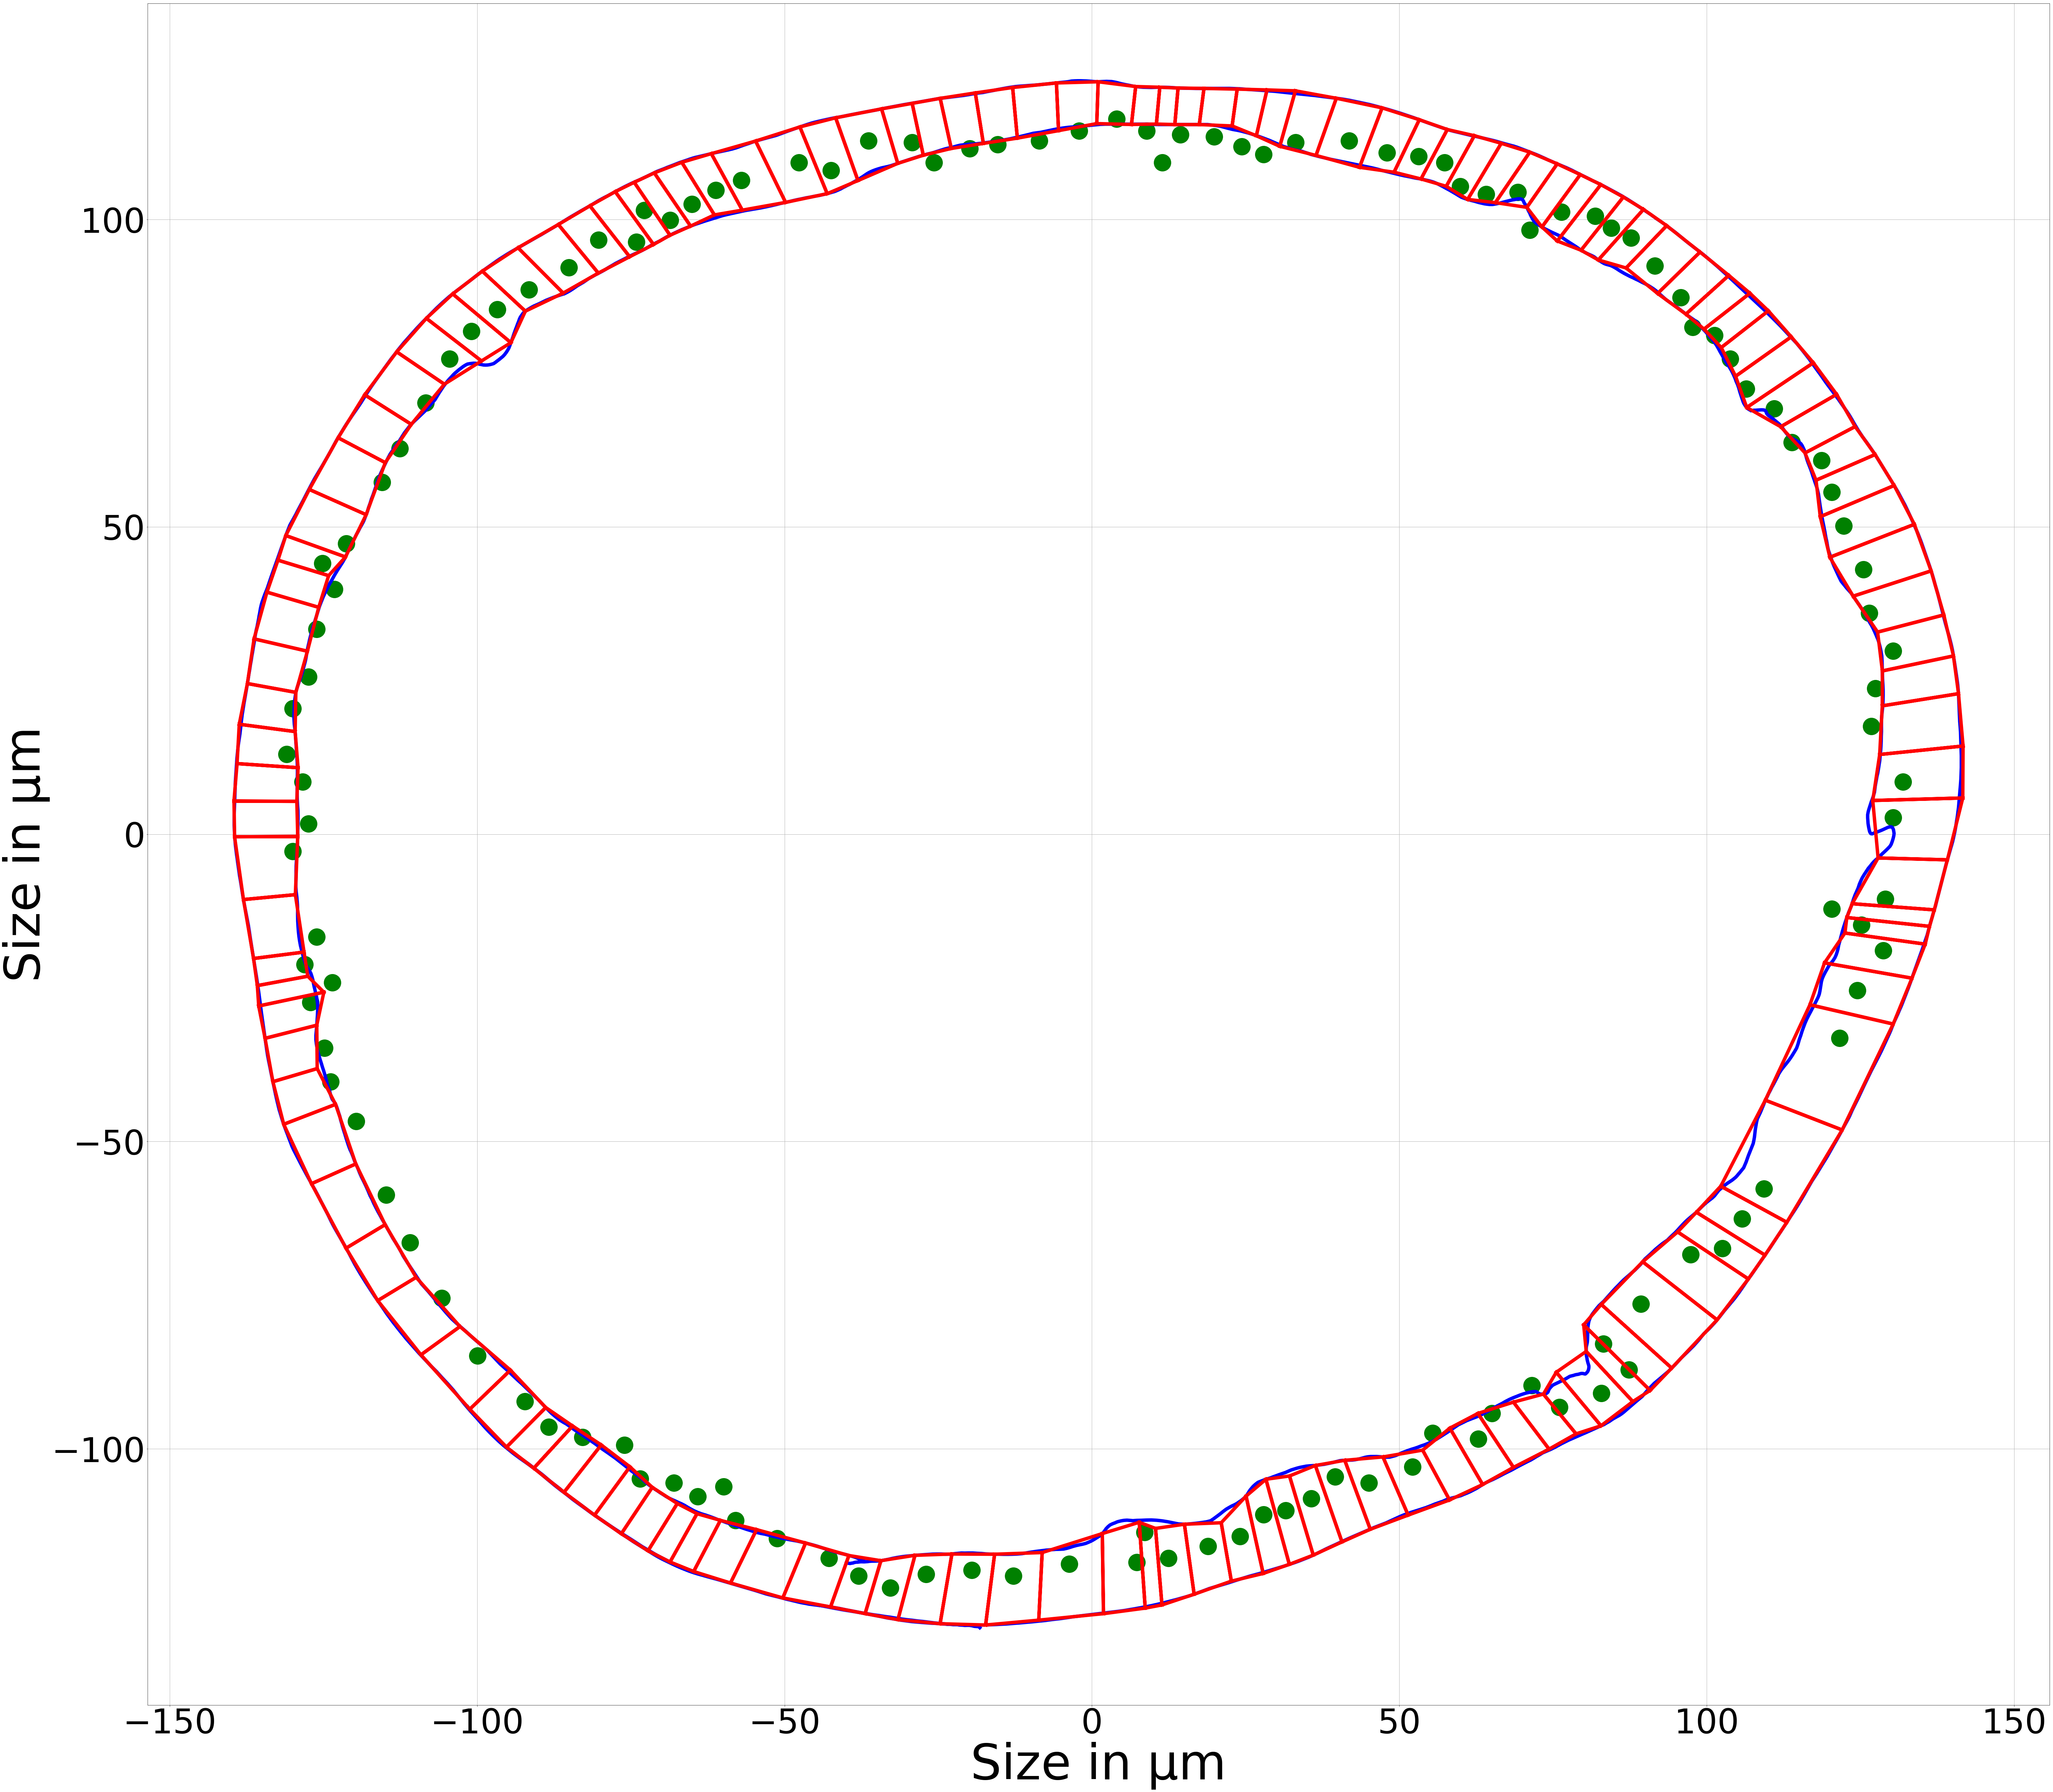

In [22]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

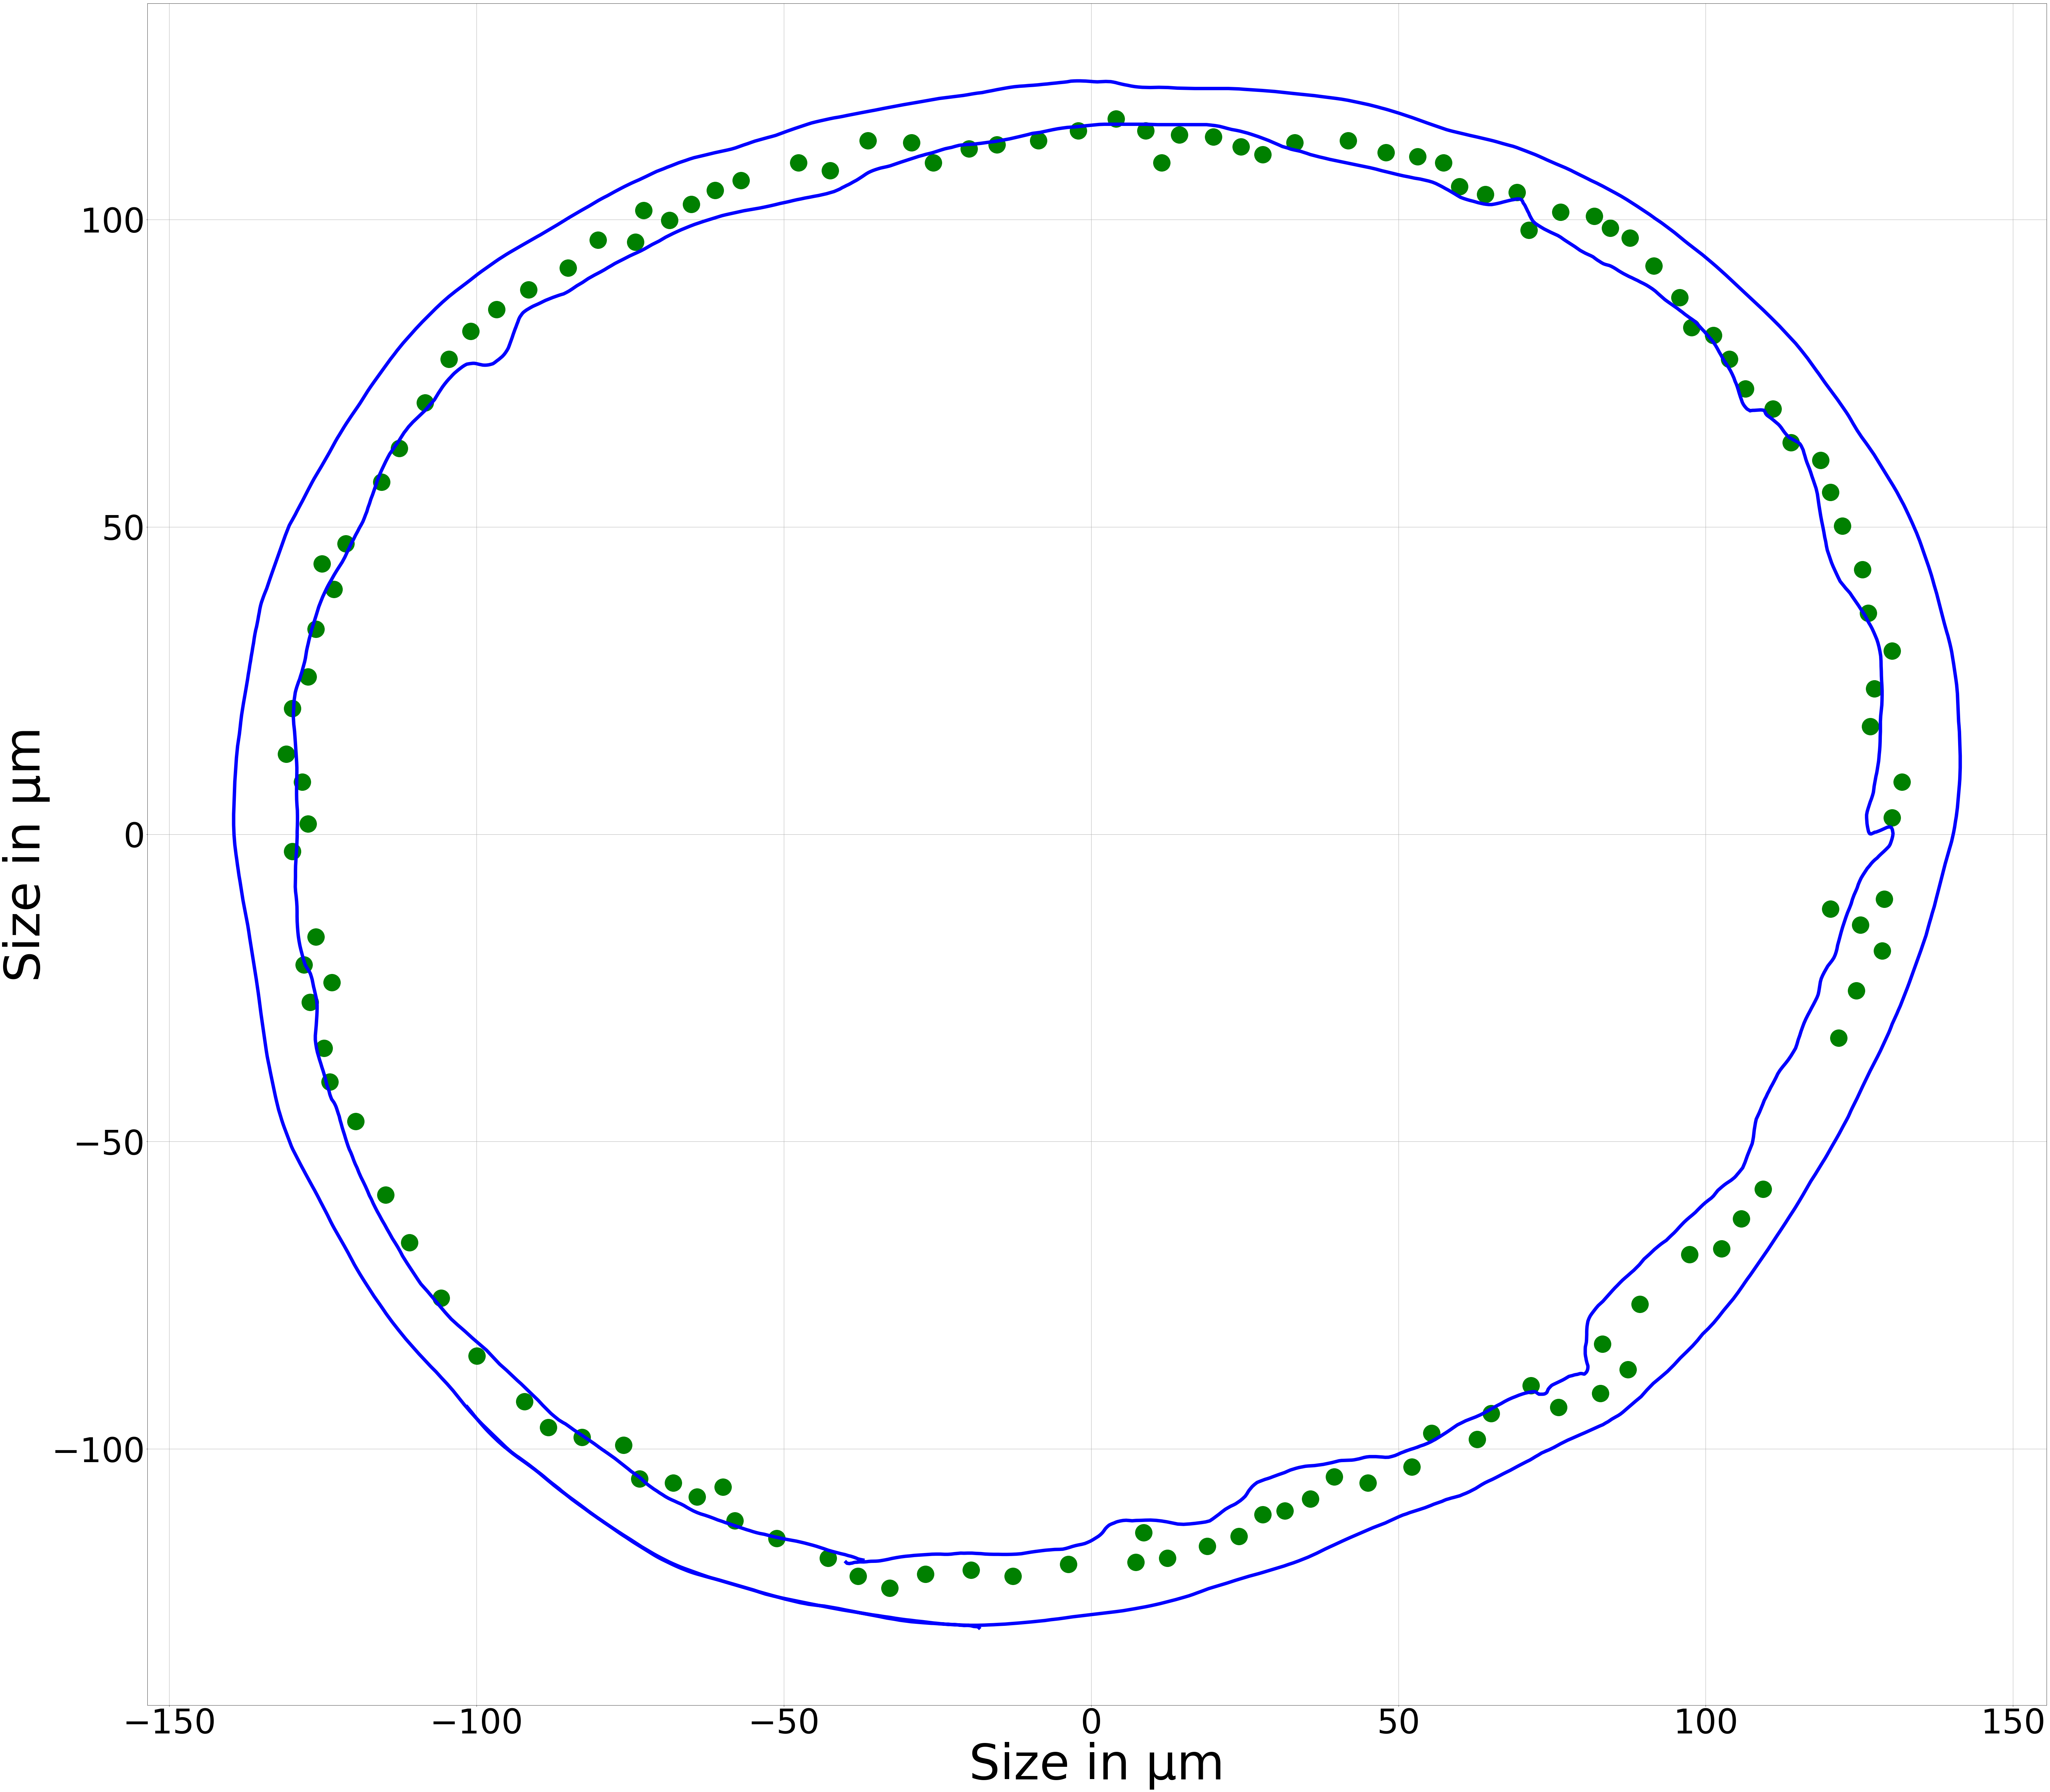

In [23]:
fig, ax = plt.subplots()
plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

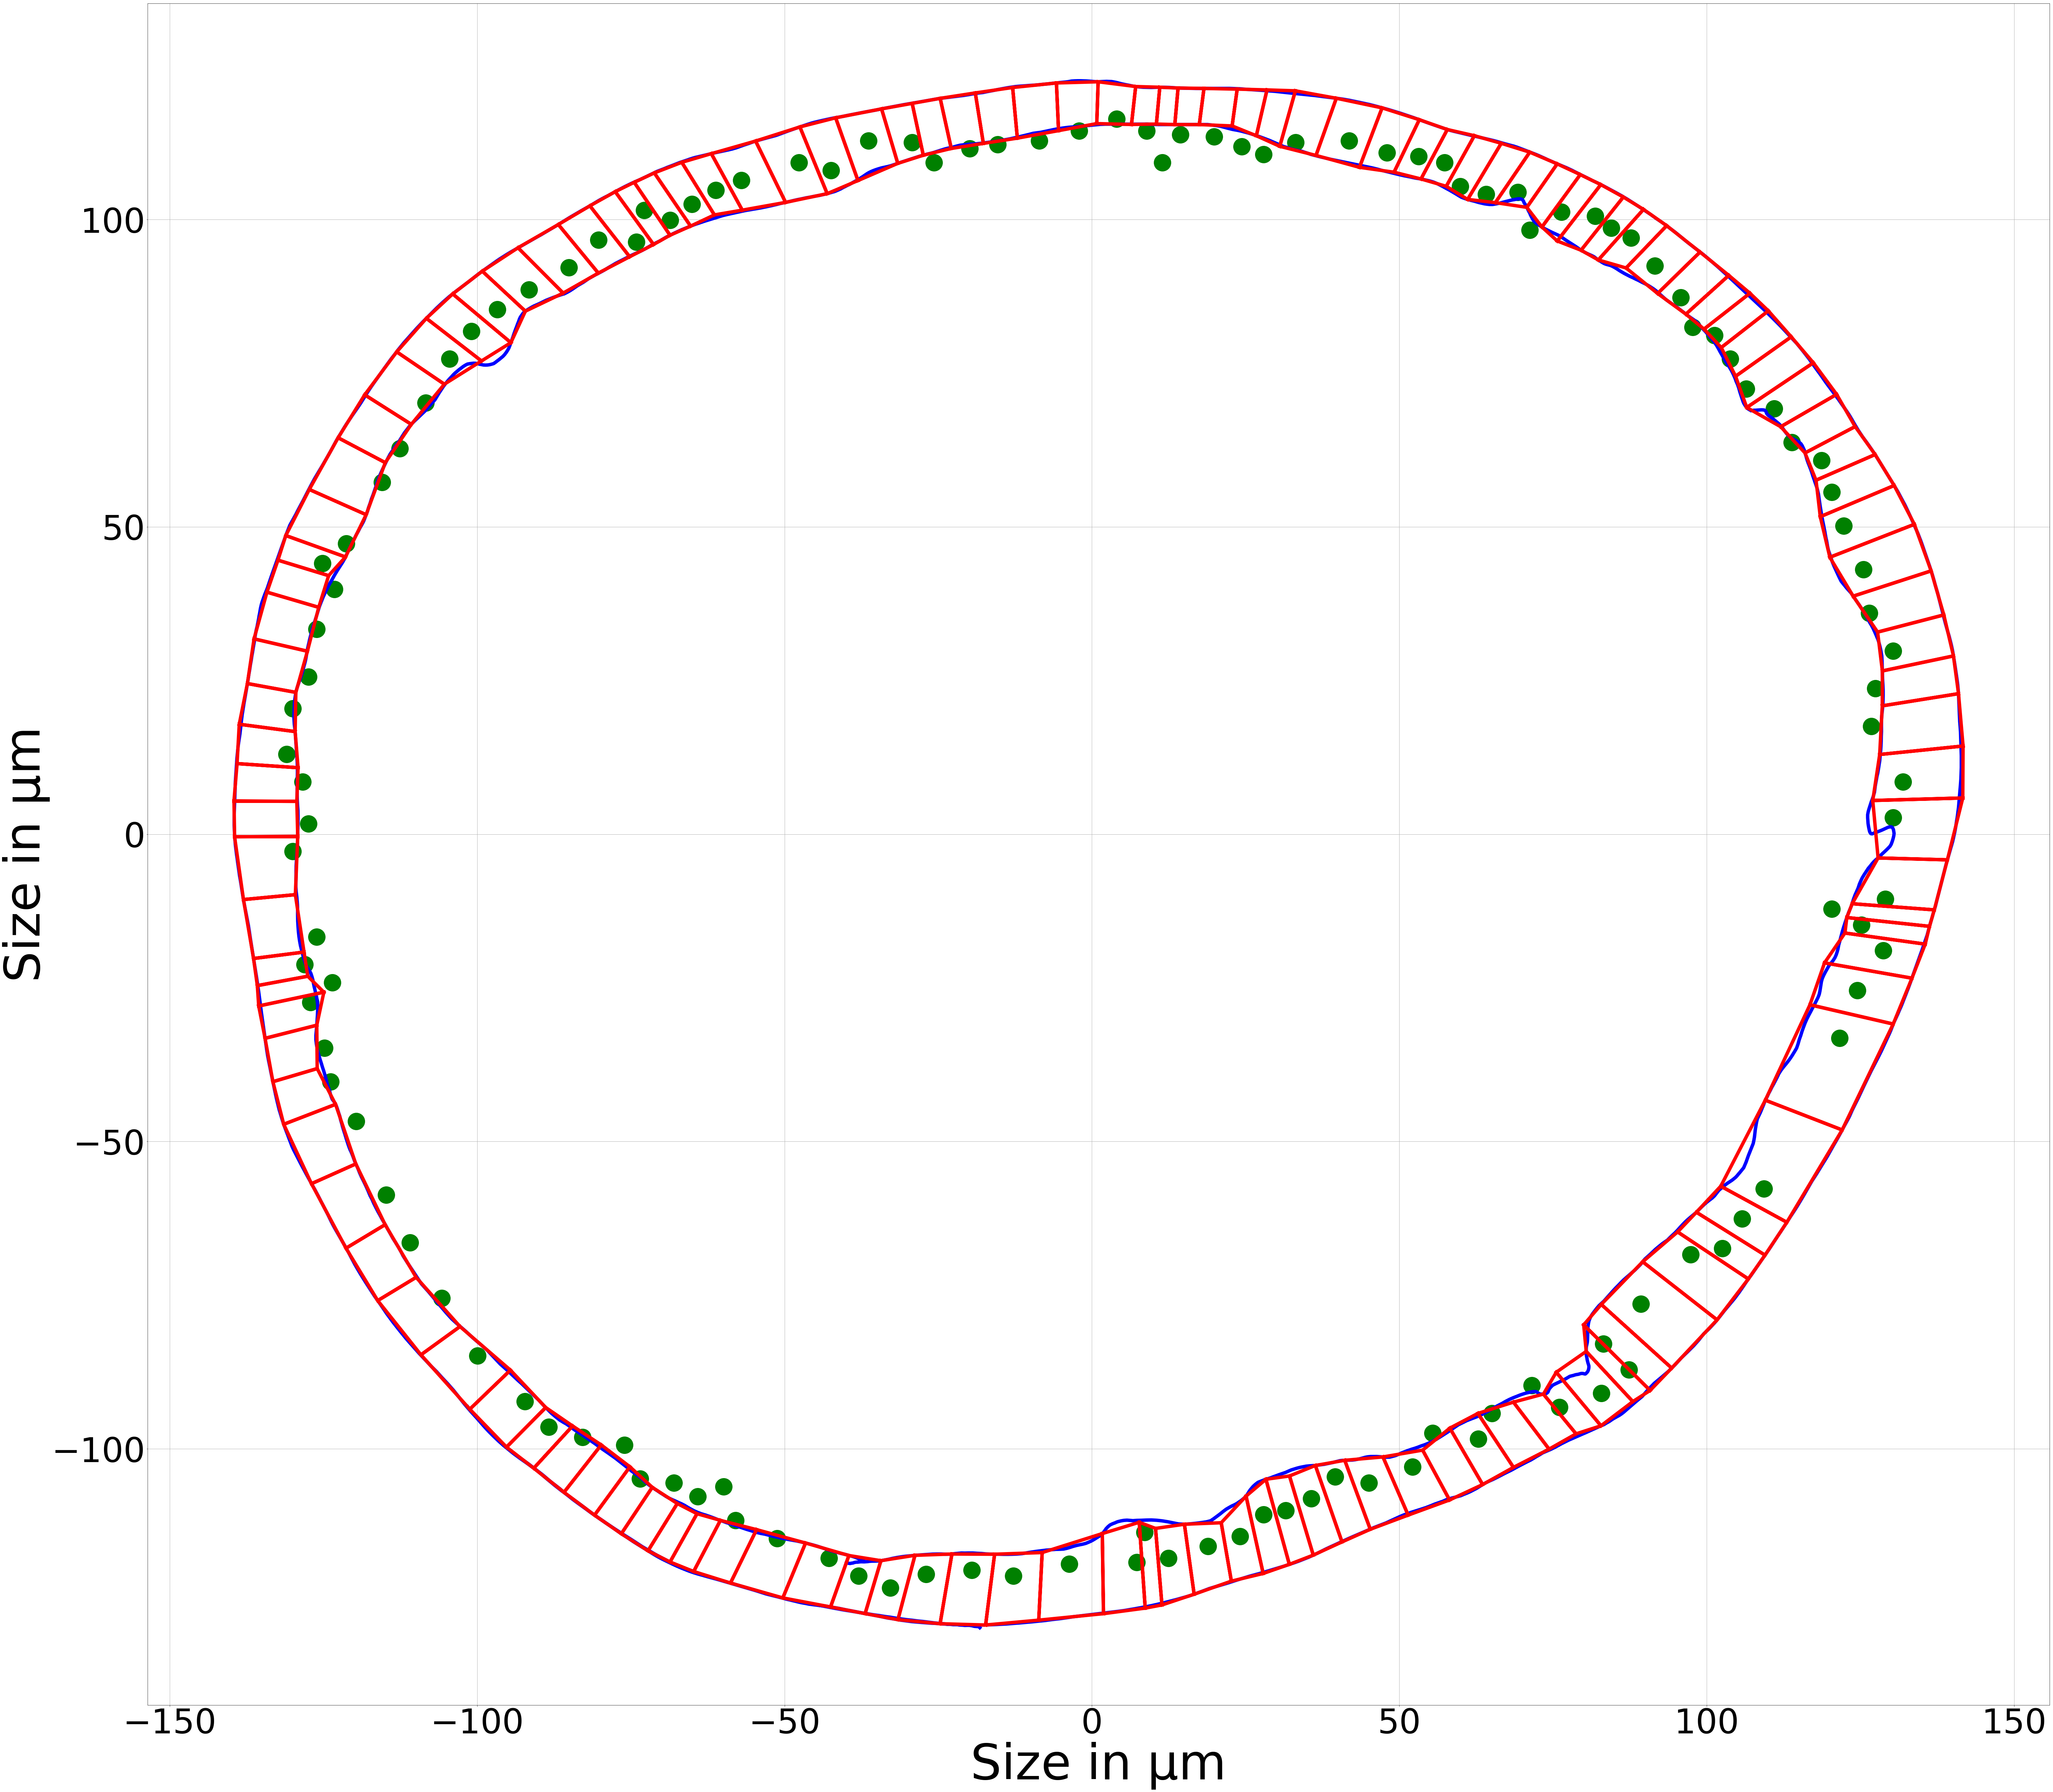

In [24]:
fig, ax = plt.subplots()

plt.plot(centers[:,0], centers[:,1], 'g.', markersize=100)
plt.plot(inners[:,0], inners[:,1], 'b-', linewidth=10)
plt.plot(outers[:,0], outers[:,1], 'b-', linewidth=10)
quick_edge_draw(organo, c='r', ax=ax, linewidth=10)
plt.xlabel('Size in µm', fontsize=144)
plt.ylabel('Size in µm', fontsize=144)
plt.tick_params(axis='both', labelsize=100)

plt.gca().set_aspect('equal', adjustable='box')
fig.set_size_inches(100, 100)
ax.grid(linestyle='-', linewidth=1)

Creating a printing function

In [3]:
def print_tensions(exp_organo, th_organo):
    draw_specs = sheet_spec()
    tension_max = np.max(exp_organo.edge_df.line_tension.values.copy())
    edge_color = 1/tension_max*exp_organo.edge_df.line_tension.values.copy()
    cmap = plt.cm.get_cmap('viridis')
    edge_cmap = cmap(edge_color)
    draw_specs['vert']['visible'] = False
    draw_specs['edge']['color'] = edge_cmap
    draw_specs['edge']['width'] = 0.25+3*edge_color
    fig, ax = quick_edge_draw(th_organo, lw=5, c='k', alpha=0.2)
    fig, ax = sheet_view(exp_organo, ax=ax, **draw_specs)
    fig.set_size_inches(12, 12)
    plt.xlabel('Size in µm')
    plt.ylabel('Size in µm')

Define the optimization parameters

In [4]:
energy_opt = {'options': {'gtol': 1e-5, 'ftol': 1e-5}}


bfgs_opt = {'method': 'bfgs','options': {'gtol':1e-1,'ftol': 1e-5}}
trf_opt = {'bounds': ([-1e-8]*(3*organo.Nf),[1000]*(3*organo.Nf)), 
           'method': 'trf','xtol':1e-8,'ftol': 1e-5, 'verbose': 2}
lm_opt = {'method': 'lm','xtol':1e-15,'ftol': 1e-15, 'verbose': 1}
psqp_opt = {'lb': 0, 'ub': 1e6, 'method': 'dist_PSQP', 'output_path': './PSQP_min_dist'}

reg_weight = 1e-3
theta = 0.02

## Starting the optimization procedure

In [5]:
initial_guess = infer_forces(organo)['tensions']
copy_lm_nr_nl = organo.copy()

In [6]:
initial_guess

array([ 3.96249716e-07,  4.81105246e-07,  5.53495320e-07,  6.03785623e-07,
        6.27860491e-07,  6.77521488e-07,  7.32573139e-07,  8.59525804e-07,
        8.50705589e-07,  8.29356834e-07,  8.17754053e-07,  9.25621655e-07,
        8.23853568e-07,  8.24035204e-07,  8.76041590e-07,  7.78564563e-07,
        5.61530751e-07, -1.08439694e-07, -4.85102957e-05,  6.64103657e-05,
       -1.52000197e-06, -2.93448180e-06, -1.77588960e-06, -4.69929978e-06,
       -2.04274918e-06, -6.13137377e-06, -3.78396043e-06,  1.98910956e-05,
       -1.74104703e-05, -2.70847088e-06,  5.73057679e-07,  4.26778694e-07,
        1.01256240e-06,  1.37868221e-06,  7.46398993e-07,  7.88743964e-07,
        6.64982314e-07,  7.70169544e-07,  1.69811107e-06,  6.36063110e-07,
        7.91211014e-07,  8.43718717e-07,  8.82415617e-07,  9.16605592e-07,
        8.64521773e-07,  8.72220766e-07,  7.83576502e-07,  7.98657507e-07,
        7.98238737e-07,  8.16024702e-07,  7.40510191e-07,  6.37528575e-07,
        5.64648311e-07,  

Energy before optimization:  216.5933862947084
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 440, initial cost 6.8589e-01, final cost 6.8589e-01, first-order optimality 5.32e-02.
Solving time: 878.173956
Energy after optimization:  11.074055020678783
Tension error: [0.99999604 0.99999519 0.99999447 0.99999396 0.99999372 0.99999322
 0.99999267 0.9999914  0.99999149 0.99999171 0.99999182 0.99999074
 0.99999176 0.99999176 0.99999124 0.99999221 0.99999438 1.00000108
 1.0004851  0.9993359  1.0000152  1.00002934 1.00001776 1.00004699
 1.00002043 1.00006131 1.00003784 0.99980109 1.0001741  1.00002708
 0.99999427 0.99999573 0.99998987 0.99998621 0.99999254 0.99999211
 0.99999335 0.9999923  0.99998302 0.99999364 0.99999209 0.99999156
 0.99999118 0.99999083 0.99999135 0.

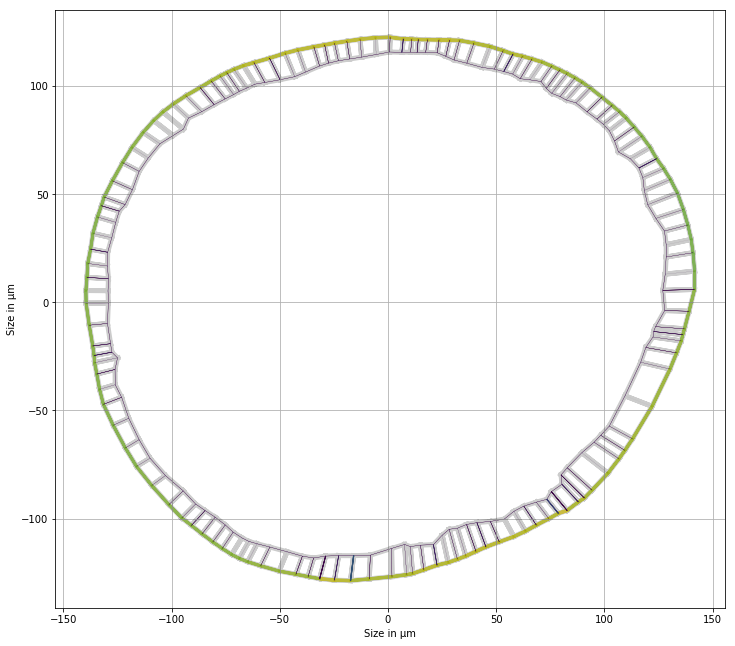

In [7]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

second try

Energy before optimization:  216.5933862947084
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'disp': False, 'ftol': 1e-06, 'gtol': 0.001}}}
{'norm_factor': 1, 'minimize': {'method': 'L-BFGS-B', 'options': {'gtol': 1e-05, 'ftol': 1e-05}}}
`xtol` termination condition is satisfied.
Function evaluations 1580, initial cost 2.6990e+03, final cost 2.4456e+03, first-order optimality 5.50e+07.
Solving time: 65640.566593
Energy after optimization:  3805.5322425517993
Tension error: [ 3.02276182  3.02277043  3.02277668  3.02277629  3.02276154  3.02278538
  3.02278413  3.02278893  3.02276749  3.02278443  3.02280448  3.02277384
  3.02279152  3.02278972  3.02276938  3.02278429  3.02277361  3.02279699
  3.02278762  3.02278986  3.02276964  3.02280277  3.02277346  3.02277379
  3.0227925   3.02279328  3.02279448  3.02278274  3.02278307  3.02282023
  3.02278013  3.0227779   3.0227901   3.02277446  3.02278059  3.0227794
  3.02279506  3.022782    3.02276948  3.02277822  3.0227949   3.0

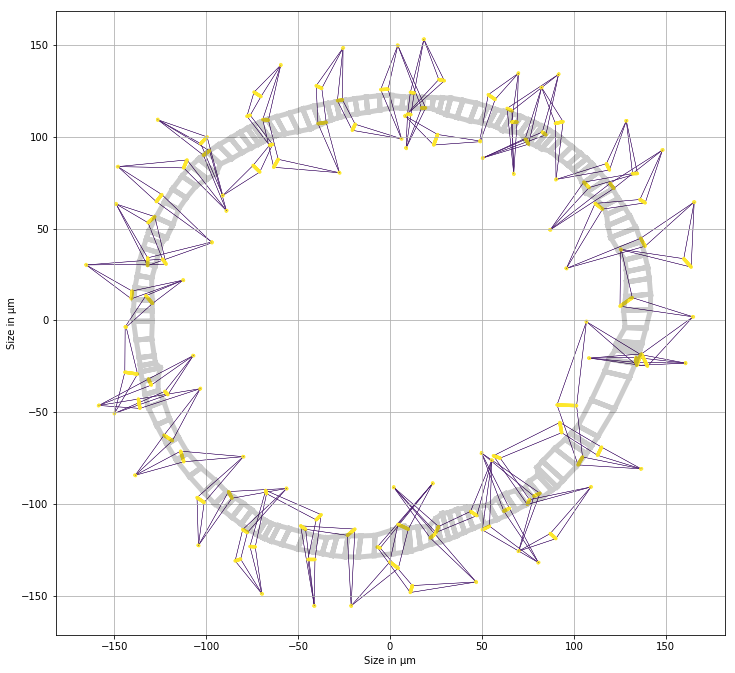

In [29]:
start = time.clock()
print('Energy before optimization: ', model.compute_energy(copy_lm_nr_nl, False))
resc_lm_nr_nl = adjust_tensions(copy_lm_nr_nl, initial_guess, {'dic':{}, 'weight':0},
                                energy_opt, **lm_opt)
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl.x)
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl.x),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

first try


Solving time: 25905.305013
Energy after optimization:  173069.65545902174
Tension error: [ 200.13881532  200.1392852   200.13935792  200.13960175  200.13919907
  200.13803355  200.13928887  200.13825485  200.13962205  200.13996098
  200.13897848  200.13871235  200.13981547  200.13961735  200.13802922
  200.13947003  200.13914418  200.1403701   200.13965397  200.13944602
  200.1389443   200.13942178  200.13814027  200.13906622  200.13915735
  200.13880416  200.13746967  200.13945617  200.13888099  200.13875323
  200.13801211  200.13960835  200.13955018  200.13929021  200.13934588
  200.14011705  200.13983581  200.13897652  200.13881795  200.13948514
  200.13845425  200.13921186  200.13966117  200.13775847  200.13958859
  200.14057786  200.13899095  200.13841782  200.13886768  200.13900226
  200.13975761  200.13859976  200.14087218  200.13919971  200.14010327
  200.13910183  200.13925985  200.13941757  200.13959903  200.13895474
  200.13938509  200.14010269  200.13947188  200.1401081   2

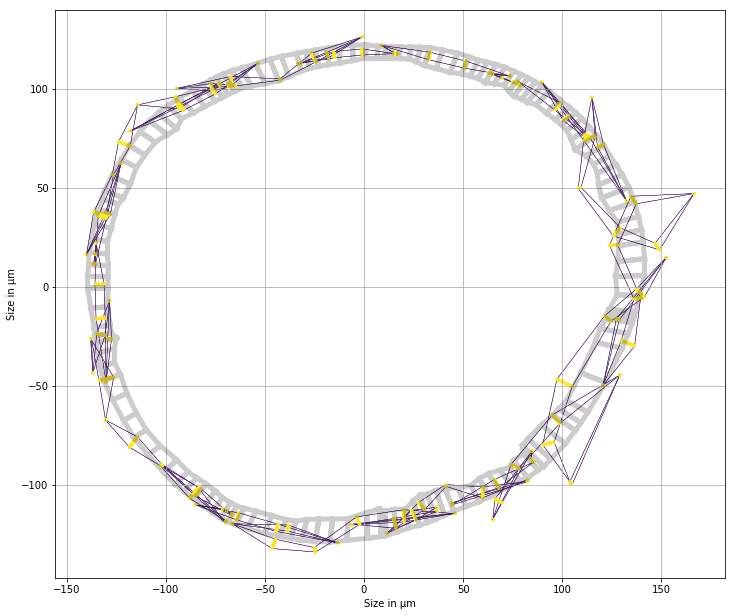

In [12]:
copy_lm_nr_nl.edge_df.line_tension = prepare_tensions(copy_lm_nr_nl, resc_lm_nr_nl['x'])
Solver.find_energy_min(copy_lm_nr_nl, geom, model)
print('Solving time: '+str(time.clock()-start))
print('Energy after optimization: ', model.compute_energy(copy_lm_nr_nl, False))
print('Tension error: '+str(np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                                             organo.edge_df.line_tension[:3*organo.Nf].values)))
print_tensions(copy_lm_nr_nl, organo)

inf 0.0


/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:107: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/home/fquinton/anaconda3/lib/python3.6/site-packages/scipy/stats/_stats_mstats_common.py:119: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)


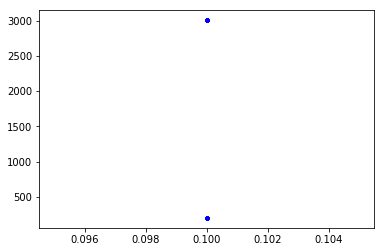

In [13]:
var_tens = np.divide(np.abs(organo.edge_df.line_tension[:3*organo.Nf].values-resc_lm_nr_nl['x']),
                     np.full(resc_lm_nr_nl['x'].shape, organo.edge_df.line_tension[:3*organo.Nf].mean()))
from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(organo.edge_df.line_tension.values[:3*Nf] ,var_tens)
print(std_err, r_value)
plt.plot(organo.edge_df.line_tension.values[:3*Nf], var_tens, 'b.')
plt.plot(organo.edge_df.line_tension.values[:3*Nf], intercept+slope*organo.edge_df.line_tension.values[:3*Nf],
        'r-')